inspired by:

https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import textwrap
import langid



In [2]:
import nltk

# Force re-download the punkt resource
nltk.download('punkt', force=True)
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('vader_lexicon')

# Check all available resources and their locations
print(nltk.data.path)

[nltk_data] Downloading package punkt to /Users/juliuseg/nltk_data...


['/Users/juliuseg/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/share/nltk_data', '/Users/juliuseg/DTU/CompTools/.venv/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliuseg/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Airbnb Dataset

### Data loading

In [3]:
# Read in data
df_full = pd.read_csv('data/reviews_airbnb.csv') # https://www.kaggle.com/datasets/nikitaryabukhin/reviewshotel?select=reviews_hotel1.csv
print(df_full.shape)
# Drop nan reviews
# df_full = df_full[df_full['reviews.text'].notna()]
df = df_full.sample(n=5000, random_state=42)
print(df.shape)


(429465, 6)
(5000, 6)


In [4]:
# Prune language of dataframe
df = df[df["comments"].apply(lambda x: langid.classify(str(x))[0] == "en")].reset_index(drop=True)

In [5]:
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,737453204440056976,934637483788032262,2023-07-13,168460048,Shianne,Elizabeth was super responsive and was kind en...
1,2907347,1226018618159306975,2024-08-18,11387465,Yannis,Thanks for having us - we loved staying in the...
2,28072056,352976661,2018-11-26,4877024,Nicola,We picked the keys up from a local safebox in ...
3,1196934327750533229,1271677691156652277,2024-10-20,259651061,Eva,Beautiful apartment in a nice quiet area! We h...
4,10746905,1023092229439000115,2023-11-12,37495796,Yusuf,"Mette was an incredible host, extrmeey friendl..."


In [6]:

# Rename the colomns for easier data replacement:
df.rename(columns={'comments': 'Review'}, inplace=True)
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,Review
0,737453204440056976,934637483788032262,2023-07-13,168460048,Shianne,Elizabeth was super responsive and was kind en...
1,2907347,1226018618159306975,2024-08-18,11387465,Yannis,Thanks for having us - we loved staying in the...
2,28072056,352976661,2018-11-26,4877024,Nicola,We picked the keys up from a local safebox in ...
3,1196934327750533229,1271677691156652277,2024-10-20,259651061,Eva,Beautiful apartment in a nice quiet area! We h...
4,10746905,1023092229439000115,2023-11-12,37495796,Yusuf,"Mette was an incredible host, extrmeey friendl..."


In [7]:
# Make example
example = df['Review'][1]
print(example)

Thanks for having us - we loved staying in the area!


### Tokens

In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['Thanks', 'for', 'having', 'us', '-', 'we', 'loved', 'staying', 'in', 'the']

In [9]:
tagged = nltk.pos_tag(tokens) # See meanings here https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
tagged[:10]

[('Thanks', 'NNS'),
 ('for', 'IN'),
 ('having', 'VBG'),
 ('us', 'PRP'),
 ('-', ':'),
 ('we', 'PRP'),
 ('loved', 'VBD'),
 ('staying', 'VBG'),
 ('in', 'IN'),
 ('the', 'DT')]

### Dictionary approach (VADER)

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


In [11]:
temp = sia.polarity_scores(example)
print (example)
print (temp)

Thanks for having us - we loved staying in the area!
{'neg': 0.0, 'neu': 0.53, 'pos': 0.47, 'compound': 0.7959}


In [12]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    # if text is float print the index and the text
    if isinstance(text, float):
        print(row['id'], text)
        continue
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

print(len(res))



  0%|          | 0/3436 [00:00<?, ?it/s]

3436


In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
merged = vaders.merge(df, on='id', how='left')

### Pretrained transformer model (Roberta)

In [14]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax



In [15]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Because im using my mac m2 where metal is gpu framework (Like cuda for nvidia)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model.to(device)

mps


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [16]:
# VADER results on example for comparison
print(example)
print(sia.polarity_scores(example))

# Roberta
# Tokenize and move tensors to the same device as model
encoded_text = tokenizer(example, return_tensors="pt")
encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

# Run inference safely on MPS
with torch.no_grad():
    output = model(**encoded_text)

# Move result to CPU for numpy operations
scores = output.logits[0].to("cpu").numpy()
scores = softmax(scores)

scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print({k: round(float(v), 3) for k, v in scores_dict.items()})

Thanks for having us - we loved staying in the area!
{'neg': 0.0, 'neu': 0.53, 'pos': 0.47, 'compound': 0.7959}
{'roberta_neg': 0.001, 'roberta_neu': 0.01, 'roberta_pos': 0.989}


#### Function to use to do entire dataset

In [17]:
def polarity_scores_roberta(example):
    # Tokenize and move to correct device
    encoded_text = tokenizer(example, return_tensors="pt")
    encoded_text = {k: v.to(device) for k, v in encoded_text.items()}

    # Inference
    with torch.no_grad():
        output = model(**encoded_text)

    # Move back to CPU for numpy conversion
    scores = output.logits[0].to("cpu").numpy()
    scores = softmax(scores)

    # Convert to normal floats
    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }


In [18]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        # if text is float print the index and the text
        if isinstance(text, float):
            print("Skipped float value on: ",row['id'], text)
            continue
        myid = row['id']
        
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/3436 [00:00<?, ?it/s]

In [19]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')
results_df.columns


Index(['id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'listing_id', 'date',
       'reviewer_id', 'reviewer_name', 'Review'],
      dtype='object')

### Plot output

/var/folders/lc/hb2ry3c568xg7y9qdybnfm280000gn/T/ipykernel_19489/3096328673.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')


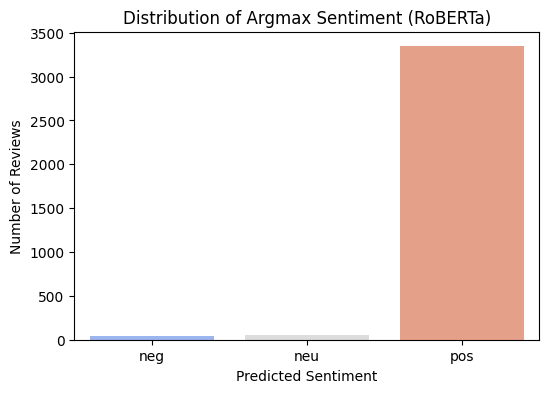

roberta_argmax
neg      41
neu      50
pos    3345
Name: count, dtype: int64


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine argmax label per row
roberta_cols = ['roberta_neg', 'roberta_neu', 'roberta_pos']
results_df['roberta_argmax'] = results_df[roberta_cols].idxmax(axis=1).str.replace('roberta_', '', regex=False)

# Count and plot
counts = results_df['roberta_argmax'].value_counts().reindex(['neg', 'neu', 'pos'])

plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')
plt.title('Distribution of Argmax Sentiment (RoBERTa)')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# Print counts
print(counts)


In [43]:
# Look at examples of positive and negative sentiment from roberta
pd.set_option('display.max_colwidth', None)
results_df.loc[results_df["roberta_label"] == "roberta_neg", ["Review"]].head(10).to_csv("temp_neg.csv", index=True)
# results_df.loc[results_df["roberta_label"] == "roberta_pos", ["Review"]].head(10).to_csv("temp_pos.csv", index=True)
results_df.loc[results_df["roberta_label"] == "roberta_pos"] \
    .nlargest(10, "roberta_neg")[["Review"]] \
    .to_csv("temp_pos.csv", index=True)



In [49]:
# look at the results of review 2448
print(results_df.loc[2448, ["roberta_neg", "roberta_neu", "roberta_pos"]])
print(results_df.loc[2448, ["Review"]])


roberta_neg    0.209584
roberta_neu    0.377613
roberta_pos    0.412803
Name: 2448, dtype: object
Review    Gustav let us check in early on short notice, and the location is great. <br/>There was disruptive construction at the building entrance which made access to the building difficult on certain days (we had to walk through the construction site every day, sometimes while heavy machinery was actively in use). The host did not inform us about the construction. <br/>The bedroom was infested with moths. (We killed about 15 during our stay. They were always around.) <br/>The bathroom is very small, and you shower directly on the floor so that when using the toilet anytime after showering, your feet get wet. <br/>The apartment was cold (the building's central heating wasn't running while we were there), so it would have been nice to have had some extra blankets for the bed and to use in the living room. The bed has two single-size light blankets. <br/>The living room is very nice and spa

In [51]:
# Do roberta for review results_df.loc[2448, ["Review"]]
print(polarity_scores_roberta(results_df.loc[2448, "Review"]))

{'roberta_neg': 0.20958395302295685, 'roberta_neu': 0.3776131272315979, 'roberta_pos': 0.41280290484428406}


In [53]:
review_text = results_df.loc[2448, "Review"]
sentences = [s.strip() for s in review_text.split(".") if s.strip()]

scores = []
for i, s in enumerate(sentences, 1):
    res = polarity_scores_roberta(s)
    scores.append(res)
    print(f"\nSentence {i}: {s}")
    print(res)

# compute average
avg_scores = {
    key: sum(d[key] for d in scores) / len(scores)
    for key in scores[0]
}

print("\nAverage scores:")
print(avg_scores)



Sentence 1: Gustav let us check in early on short notice, and the location is great
{'roberta_neg': 0.0016996676567941904, 'roberta_neu': 0.01711949147284031, 'roberta_pos': 0.9811809062957764}

Sentence 2: <br/>There was disruptive construction at the building entrance which made access to the building difficult on certain days (we had to walk through the construction site every day, sometimes while heavy machinery was actively in use)
{'roberta_neg': 0.7301221489906311, 'roberta_neu': 0.25009462237358093, 'roberta_pos': 0.019783178344368935}

Sentence 3: The host did not inform us about the construction
{'roberta_neg': 0.39497601985931396, 'roberta_neu': 0.5840246081352234, 'roberta_pos': 0.020999424159526825}

Sentence 4: <br/>The bedroom was infested with moths
{'roberta_neg': 0.872447669506073, 'roberta_neu': 0.120877705514431, 'roberta_pos': 0.006674612406641245}

Sentence 5: (We killed about 15 during our stay
{'roberta_neg': 0.7139945030212402, 'roberta_neu': 0.274267911911010

### Word clouds

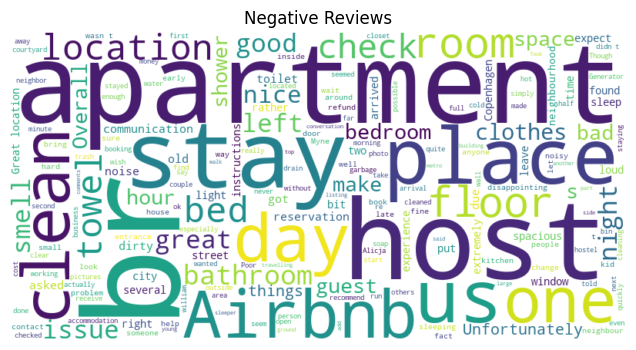

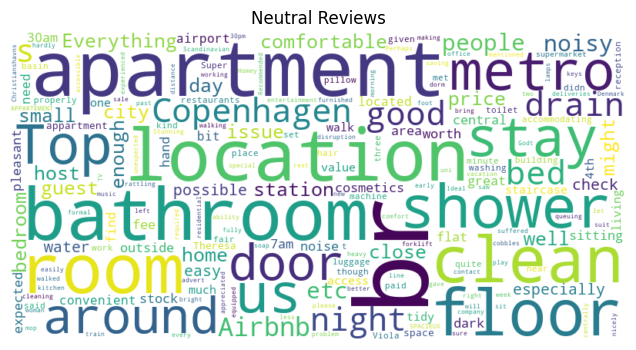

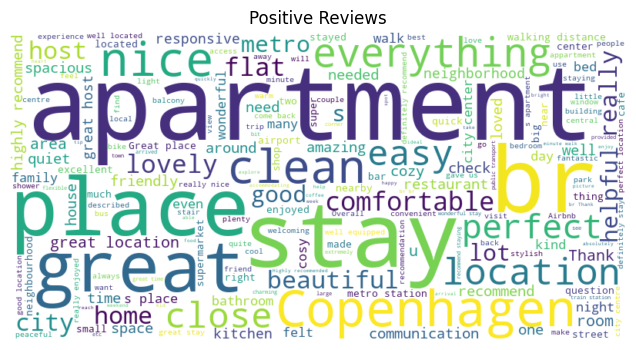

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Determine which sentiment dominates
results_df["roberta_label"] = results_df[["roberta_neg", "roberta_neu", "roberta_pos"]].idxmax(axis=1)

# Combine all text for each sentiment
neg_text = " ".join(results_df.loc[results_df["roberta_label"] == "roberta_neg", "Review"].astype(str))
neu_text = " ".join(results_df.loc[results_df["roberta_label"] == "roberta_neu", "Review"].astype(str))
pos_text = " ".join(results_df.loc[results_df["roberta_label"] == "roberta_pos", "Review"].astype(str))

# Helper function
def make_wc(text, title):
    wc = WordCloud(width=800, height=400, background_color="white", stopwords=None).generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Create 3 word clouds
make_wc(neg_text, "Negative Reviews")
make_wc(neu_text, "Neutral Reviews")
make_wc(pos_text, "Positive Reviews")


### Weight by how much more they appear in postive than negative

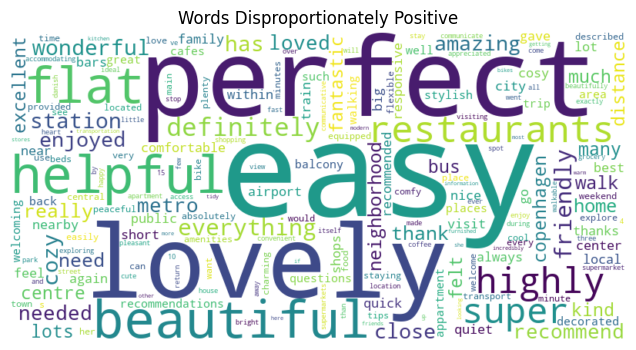

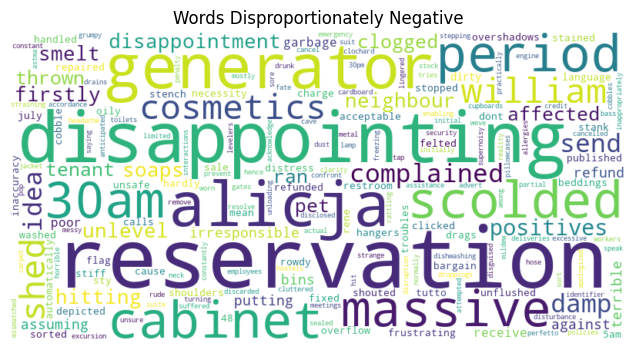

In [22]:
from collections import Counter
import numpy as np
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

def make_weighted_wc(group1_texts, group2_texts, title):
    # Count words
    c1 = Counter(token for text in group1_texts for token in tokenize(str(text)))
    c2 = Counter(token for text in group2_texts for token in tokenize(str(text)))

    # Compute weighted ratio
    weights = {}
    for w in set(c1.keys()) | set(c2.keys()):
        a, b = c1[w], c2[w]
        weights[w] = a / max(b, 1)  # avoid divide-by-zero

    # Build word cloud from weighted frequencies
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(weights)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Example usage
pos_texts = results_df.loc[results_df.roberta_neg < results_df.roberta_pos, "Review"]
neg_texts = results_df.loc[results_df.roberta_pos < results_df.roberta_neg, "Review"]

make_weighted_wc(pos_texts, neg_texts, "Words Disproportionately Positive")
make_weighted_wc(neg_texts, pos_texts, "Words Disproportionately Negative")


### Tests

In [23]:
print(df_full.shape,"\n", df_full.columns)



(429465, 6) 
 Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')


In [24]:
df_full.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1312191,6662965,2013-08-20,7403659,Anne,Nous sommes des français qui avons découvert l...


In [25]:
df_full['listing_id'].nunique()




19538

In [26]:
# Read in data
cluster_df = pd.read_csv('data/cluster_temp.csv') # https://www.kaggle.com/datasets/nikitaryabukhin/reviewshotel?select=reviews_hotel1.csv

cluster_df = cluster_df.rename(columns={"id": "listing_id"})


print(cluster_df.shape)
print(cluster_df.columns)
print(cluster_df["listing_id"].nunique())
# Rename "id" columns in both cluster_df and results_df to "listing_id"


# Drop nan reviews
# df_full = df_full[df_full['reviews.text'].notna()]
# df = cluster_df.head(5000)
# print(df.shape)


(13225, 5)
Index(['listing_id', 'host_id', 'name', 'neighbourhood_cleansed',
       'cluster_kmeans'],
      dtype='object')
13225


In [27]:
# Only keep rows from results_df where listing_id exists in cluster_df
merged_df = results_df[results_df["listing_id"].isin(cluster_df["listing_id"])].merge(cluster_df, on="listing_id", how="left")

In [28]:
merged_df.head(5)

,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,listing_id,date,reviewer_id,reviewer_name,Review,roberta_argmax,roberta_label,host_id,name,neighbourhood_cleansed,cluster_kmeans
0,934637483788032262,0.0,0.556,0.444,0.9738,0.001480,0.014036,0.984484,737453204440056976,2023-07-13,168460048,Shianne,Elizabeth was super responsive and was kind en...,pos,roberta_pos,64023897,Lejlighed centralt i Valby,Valby,0
1,1226018618159306975,0.0,0.530,0.470,0.7959,0.001268,0.009557,0.989175,2907347,2024-08-18,11387465,Yannis,Thanks for having us - we loved staying in the...,pos,roberta_pos,14853464,Nice getaway at Vesterbro,Vesterbro-Kongens Enghave,3
2,352976661,0.0,0.670,0.330,0.9153,0.001350,0.033891,0.964759,28072056,2018-11-26,4877024,Nicola,We picked the keys up from a local safebox in ...,pos,roberta_pos,860763,Modern duplex with unique location,Indre By,0
3,1271677691156652277,0.0,0.393,0.607,0.8955,0.001528,0.007364,0.991108,1196934327750533229,2024-10-20,259651061,Eva,Beautiful apartment in a nice quiet area! We h...,pos,roberta_pos,18208160,Lys lejlighed i rolige Nordvest,Vanlse,4
4,1023092229439000115,0.0,0.539,0.461,0.9370,0.001663,0.008365,0.989972,10746905,2023-11-12,37495796,Yusuf,"Mette was an incredible host, extrmeey friendl...",pos,roberta_pos,55223560,Spacious designer apartment,sterbro,4


In [29]:
num_nans_id = merged_df['id'].isna().sum()
num_nans_neighborhood = merged_df['neighbourhood_cleansed'].isna().sum()
print(f"Number of NaNs in 'id': {num_nans_id}")
print(f"Number of NaNs in 'neighbourhood_cleansed': {num_nans_neighborhood}")


Number of NaNs in 'id': 0
Number of NaNs in 'neighbourhood_cleansed': 0


### Word clouds for clusters

(399,) (11,)


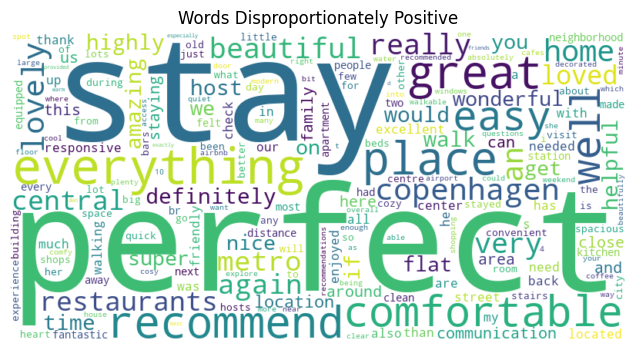

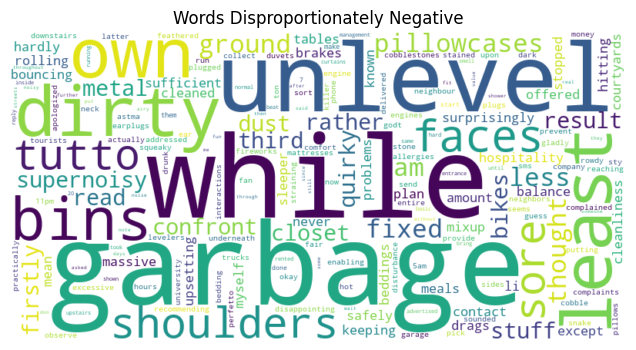

In [30]:

# Example usage
pos_texts_1 = merged_df.loc[(merged_df.roberta_neg < merged_df.roberta_pos) & (merged_df.cluster_kmeans == 1), "Review"]
neg_texts_1 = merged_df.loc[(merged_df.roberta_pos < merged_df.roberta_neg) & (merged_df.cluster_kmeans == 1), "Review"]

print(pos_texts_1.shape, neg_texts_1.shape)

make_weighted_wc(pos_texts_1, neg_texts_1, "Words Disproportionately Positive")
make_weighted_wc(neg_texts_1, pos_texts_1, "Words Disproportionately Negative")


(93,) (1,)


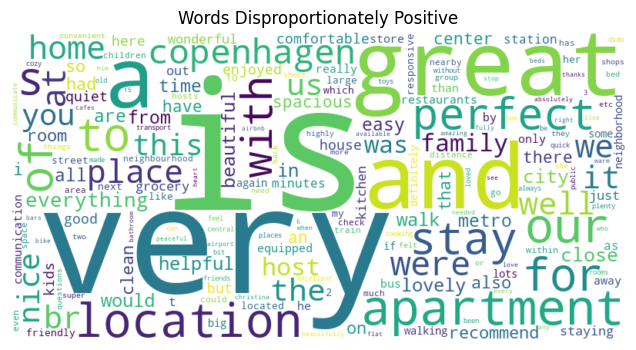

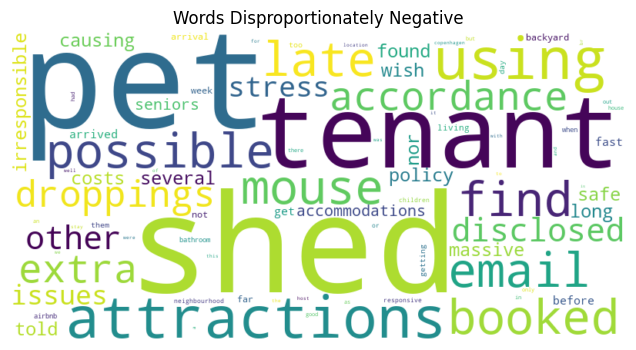

In [31]:
pos_texts_2 = merged_df.loc[(merged_df.roberta_neg < merged_df.roberta_pos) & (merged_df.cluster_kmeans == 2), "Review"]
neg_texts_2 = merged_df.loc[(merged_df.roberta_pos < merged_df.roberta_neg) & (merged_df.cluster_kmeans == 2), "Review"]

print(pos_texts_2.shape, neg_texts_2.shape)

make_weighted_wc(pos_texts_2, neg_texts_2, "Words Disproportionately Positive")
make_weighted_wc(neg_texts_2, pos_texts_2, "Words Disproportionately Negative")
